In [1]:
import numpy as np
import pandas as pd
import dowhy
import matplotlib.pyplot as plt
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns',35)
import sys
sys.path.append("../scripts/")
#from plot import plot_distribution
import warnings
warnings.filterwarnings('ignore')
from dowhy import CausalModel
from IPython.display import Image, display

In [2]:
df = pd.read_csv("../data/data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


* Feature selection - logistic regression

In [3]:
df = df.drop(['id', 'Unnamed: 32'], axis=1)

In [5]:
x = {'B':0, 'M':1}
df['diagnosis'] = df['diagnosis'].map(x)

The target column is changed from a cateogrical value to a numerical value by representing 'B' with 0 and 'M' with 1

In [6]:
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, random_state=20, test_size=0.2)

#X = train.drop(['diagnosis'],axis=1)
#y = df.diagnosis.values

print('Train: ', train.shape)
print('Hold-out: ', test.shape)

Train:  (455, 31)
Hold-out:  (114, 31)


In [8]:
xs = train.iloc[:,2:].columns.tolist()

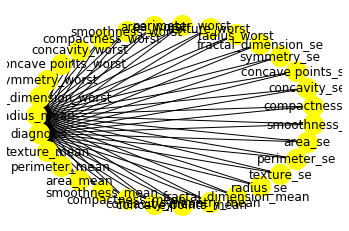

In [9]:
# Create a causal model from the train data.
model= CausalModel(
        data = train,
        #graph=causal_graph.replace("\n", " "),
        treatment='radius_mean',
        outcome='diagnosis',
        common_causes=xs
)
model.view_model()

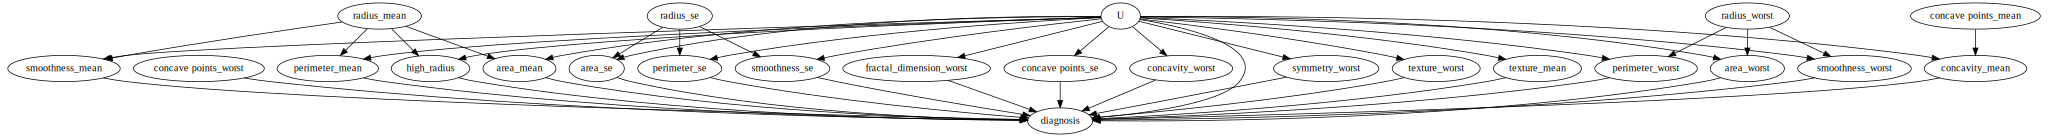

In [10]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'concavity_mean', 'concave points_mean', 'radius_se',
       'perimeter_se', 'area_se', 'smoothness_se', 'concave points_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis',
       'high_radius','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean","smoothness_mean"),
        ("concave points_mean","concavity_mean"),
        ("radius_mean","high_radius"),
        ("radius_se", "perimeter_se"), 
        ("radius_se", "area_se"),
        ("radius_se","smoothness_se"),
        ("radius_worst", "perimeter_worst"), 
        ("radius_worst", "area_worst"),
        ("radius_worst","smoothness_worst"),
        ("concave points_worst","concavity worst"),
        ("U","perimeter_mean"),
        ("U","area_mean"),
        ("U","texture_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
        ("U","perimeter_se"),
        ("U","area_se"),
        ("U","concave points_se"),
        ("U","smoothness_se"),
        ("U","perimeter_worst"),
        ("U","area_worst"),
        ("U","texture_worst"),
        ("U","smoothness_worst"),
        ("U","concavity_worst"),
        ("U","symmetry_worst"),
        ("U","fractal_dimension_worst"),
        ("U","high_radius"),
        ("U","diagnosis"),
        ("high_radius","diagnosis"),
        ("perimeter_mean","diagnosis"),
        ("area_mean","diagnosis"),
        ("texture_mean","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("perimeter_se","diagnosis"),
        ("area_se","diagnosis"),
        ("smoothness_se","diagnosis"),
        ("concavity_se","diagnosis"),
        ("smoothness_se","diagnosis"),
        ("concave points_se","diagnosis"),
        ("concave points_worst","diagnosis"),
        ("perimeter_worst","diagnosis"),
        ("area_worst","diagnosis"),
        ("texture_worst","diagnosis"),
        ("smoothness_worst","diagnosis"),
        ("concavity_worst","diagnosis"),
        ("smoothness_worst","diagnosis"),
        ("symmetry_worst","diagnosis"),
        ("fractal_dimension_worst","diagnosis")
    ]
)
# draw return a graphviz `dot` object, which jupyter can render
causal.draw()

The ground truth graph

In [ ]:
from causalgraphicalmodels import CausalGraphicalModel
causal2 = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','texture_mean','radius_worst','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean", "texture_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
         ("radius_worst", "texture_mean"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
         ("U","radius_worst"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
causal2.draw()

In [11]:
# Identify the Causal Effect
estimands = model.identify_effect()
print(estimands)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_se,radius_se,symmetry_mean,area
d[radiusₘₑₐₙ]                                                                 

                                                                              
_mean,symmetry_se,concave points_mean,concave points_worst,fractal_dimension_s
                                                                              

                                                                              
e,radius_worst,perimeter_mean,area_worst,fractal_dimension_mean,texture_se,com
                                                                              

                                                                              
pactness_mean,perimeter_worst,texture_mean,fractal_dimension_worst,concave poi
                                

In [12]:
# Estimate the causal effect and compare it with Average Treatment Effect
estimate = model.estimate_effect(estimands,
        method_name="backdoor.linear_regression", test_significance=True
)

print(estimate)

print("Causal Estimate is " + str(estimate.value))
data_1 = train[train["diagnosis"]==1]
data_0 = train[train["diagnosis"]==0]

print("ATE", np.mean(data_1["radius_mean"])- np.mean(data_0["radius_mean"]))

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|smoothness_se,radius_se,symmetry_mean,area
d[radiusₘₑₐₙ]                                                                 

                                                                              
_mean,symmetry_se,concave points_mean,concave points_worst,fractal_dimension_s
                                                                              

                                                                              
e,radius_worst,perimeter_mean,area_worst,fractal_dimension_mean,texture_se,com
                                                                              

                                                                              
pactness_mean,perimeter_worst,texture_mean,fractal_dimension_wo

In [16]:
# Testing our assumption validity

Random Common Cause

* adds an independent random variable as a common cause to the train data
* if the assumption was correct, the estimation should not change.

In [13]:
refute_train = model.refute_estimate(estimands,estimate, "random_common_cause")
print(refute_train)

Refute: Add a Random Common Cause
Estimated effect:-0.45180201969615297
New effect:-0.4476189370503185



The effect changed by a negligible amount, meaning our assumption could be accurate

Data Subset Refuter

* replaces the given dataset with a randomly selected subset
* if the assumption was correct, the estimation should not change that much.

In [14]:
refute_train = model.refute_estimate(estimands,estimate,"data_subset_refuter")
print(refute_train)

Refute: Use a subset of data
Estimated effect:-0.45180201969615297
New effect:-0.4595248938095658
p value:0.48



The change is by 0.001 which is quite small, hence our assumptions may be correct

Placebo Treatment

* replaces the true treatment variable with an independent random variable
* if the assumption was correct, the estimate should go close to zero.

In [15]:
refute_train = model.refute_estimate(estimands,estimate, "placebo_treatment_refuter")
print(refute_train)

Refute: Use a Placebo Treatment
Estimated effect:-0.45180201969615297
New effect:2.67447397561682e-10
p value:0.0



Training using only the variables that point directly to the target variable

In [18]:
df['low_radius'] = df['radius_mean'].apply(lambda x: True if x < 18 else False)

In [20]:
train_features = {'diagnosis','radius','area','perimeter','compactness','smoothness','concave points','concavity'}
train_columns = [col for col in df 
                      if any(feature in col for feature in train_features)]

In [22]:
training = df[train_columns]
training = training.drop(training.filter(regex = '_worst').columns,axis=1)
training = training.drop(training.filter(regex = '_se').columns,axis=1)
training.rename(columns={'concave points_mean':'concave_points_mean'},inplace=True)
training.head()

,diagnosis,radius_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,low_radius
0,1,17.99,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,True
1,1,20.57,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,False
2,1,19.69,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,False
3,1,11.42,77.58,386.1,0.14250,0.28390,0.2414,0.10520,True
4,1,20.29,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,False


In [23]:
causal_graph = """
digraph{

radius_mean;
perimeter_mean;
area_mean;
smoothness_mean;
compactness_mean;
concavity_mean;
concave_points_mean;
U[label="Unobserved Confounders"];
radius_mean -> perimeter_mean;radius_mean -> area_mean;radius_mean -> smoothness_mean;radius_mean->low_radius;area_mean->compactness_mean;
perimeter_mean->compactness_mean;concave_points_mean->concavity_mean;
U->compactness_mean;U->smoothness_mean;U->concavity_mean;U->low_radius;U->diagnosis;
compactness_mean->diagnosis;smoothness_mean->diagnosis;concavity_mean->diagnosis;low_radius->diagnosis;
}
"""

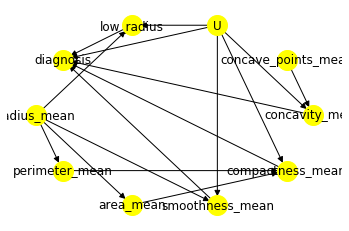

In [26]:
model2 = CausalModel(
        data = training,
        graph=causal_graph.replace("\n", " "),
        treatment='low_radius',
        outcome='diagnosis')
model2.view_model()

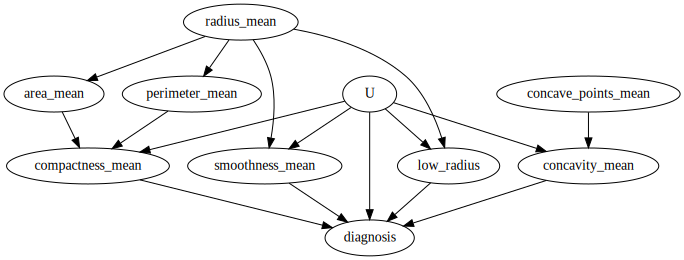

In [27]:
#area and perimeter functions of radius
from causalgraphicalmodels import CausalGraphicalModel
causal = CausalGraphicalModel(
    nodes=['radius_mean','perimeter_mean','area_mean','smoothness_mean','compactness_mean','concavity_mean',
           'concave_points_mean','diagnosis','low_radius','U'],
    edges=[
        ("radius_mean", "perimeter_mean"), 
        ("radius_mean", "area_mean"),
        ("radius_mean","smoothness_mean"),
        ("radius_mean","low_radius"),
        ("area_mean","compactness_mean"),
        ("perimeter_mean","compactness_mean"),
        ("concave_points_mean","concavity_mean"),
        ("U","compactness_mean"),
        ("U","smoothness_mean"),
        ("U","concavity_mean"),
        ("U","low_radius"),
        ("U","diagnosis"),
        ("low_radius","diagnosis"),
        ("smoothness_mean","diagnosis"),
        ("concavity_mean","diagnosis"),
        ("compactness_mean","diagnosis")
    ]
)
causal.draw()

In [28]:
estimands2 = model2.identify_effect()
print(estimands2)

WARN: Do you want to continue by ignoring any unobserved confounders? (use proceed_when_unidentifiable=True to disable this prompt) [y/n] y
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|concave_points_mean,area_mean,smoothness_m
d[low_radius]                                                                 

                                                                
ean,perimeter_mean,compactness_mean,concavity_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,concave_points_mean,area_mean,smoothness_mean,perimeter_mean,compactness_mean,concavity_mean,radius_mean,U) = P(diagnosis|low_radius,concave_points_mean,area_mean,smoothness_mean,perimeter_mean,compactness_mean,concavity_mean,ra

In [29]:
# Causal Effect Estimation
# Method based on estimating the treatment assignment
estimate = model2.estimate_effect(estimands2,method_name = "backdoor.propensity_score_weighting")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                                                                       
─────────────(Expectation(diagnosis|concave_points_mean,area_mean,smoothness_m
d[low_radius]                                                                 

                                                                
ean,perimeter_mean,compactness_mean,concavity_mean,radius_mean))
                                                                
Estimand assumption 1, Unconfoundedness: If U→{low_radius} and U→diagnosis then P(diagnosis|low_radius,concave_points_mean,area_mean,smoothness_mean,perimeter_mean,compactness_mean,concavity_mean,radius_mean,U) = P(diagnosis|low_radius,concave_points_mean,area_mean,smoothness_mean,perimeter_mean,compactness_mean,concavity_mean,radius_mean)

## Realized estimand
b: diagnosis~low_radius+concave_points_mean+area_mean+smoot

In [ ]:
# Constraint on diagnosis column with lasso regularization

In [30]:
refute_train = model2.refute_estimate(estimands2,estimate, "random_common_cause")
print(refute_train)

Refute: Add a Random Common Cause
Estimated effect:0.03847446109870464
New effect:0.04134835284814212



In [31]:
refute_train = model2.refute_estimate(estimands2,estimate,"data_subset_refuter")
print(refute_train)

Refute: Use a subset of data
Estimated effect:0.03847446109870464
New effect:0.042493210478959646
p value:0.38



In [32]:
refute_train = model2.refute_estimate(estimands2,estimate, "placebo_treatment_refuter")
print(refute_train)

Refute: Use a Placebo Treatment
Estimated effect:0.03847446109870464
New effect:-0.0011565682193687332
p value:0.48



In [35]:
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.structure.notears import from_pandas_lasso
sm = from_pandas(train_df.iloc[:, :12], tabu_parent_nodes=['diagnosis'],)

ModuleNotFoundError: No module named 'causalnex'